In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# === Settings ===
directories = [
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Training_day1',
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Training_day6',
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day3',
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Visual_mismatch_day4',
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Vestibular_mismatch_day1',
    '/Volumes/RanczLab2/20250409_Cohort3_rotation/Open_loop_day1'
]

# Duration in minutes for each directory
durations_in_minutes = {
    'Training_day1': 20,
    'Training_day6': 30,
    'Visual_mismatch_day3': 30,
    'Visual_mismatch_day4': 30,
    'Vestibular_mismatch_day1': 26,
    'Open_loop_day1': 30

}

column_to_analyze = 'Position_0X'
parquet_filename = 'alldata_asynchronous.parquet'
smoothing_window = 20
output_filename = 'distance_and_speed_comparison.png'

# === Processing Function ===
def compute_distance(directory, duration_minutes):
    distances_per_min = []
    speeds_m_per_s = []

    for root, dirs, files in os.walk(directory):
        if root.endswith('processedData'):
            parquet_path = os.path.join(root, parquet_filename)
            if os.path.exists(parquet_path):
                try:
                    df = pd.read_parquet(parquet_path)

                    if column_to_analyze in df.columns:
                        position = df[column_to_analyze].dropna()
                        if len(position) < 2:
                            continue

                        # Smoothing
                        position_smoothed = position.rolling(window=smoothing_window, min_periods=1).mean().dropna()

                        # Total distance
                        total_distance = np.abs(np.diff(position_smoothed)).sum()

                        # Compute values based on provided duration
                        dist_per_min = total_distance / duration_minutes
                        speed_m_per_s = total_distance / (duration_minutes * 60)

                        distances_per_min.append(dist_per_min)
                        speeds_m_per_s.append(speed_m_per_s)
                    else:
                        print(f"[!] Column '{column_to_analyze}' missing in: {parquet_path}")
                except Exception as e:
                    print(f"[!] Error reading {parquet_path}: {e}")
    return np.array(distances_per_min), np.array(speeds_m_per_s)

# === Run analyses ===
distance_data = []
speed_data = []
labels = []

for dir_path in directories:
    folder_label = os.path.basename(dir_path.rstrip('/'))
    duration = durations_in_minutes.get(folder_label)

    if duration is None:
        print(f"⚠️ No duration defined for {folder_label}. Skipping.")
        continue

    distances, speeds = compute_distance(dir_path, duration)

    if len(distances) > 0 and len(speeds) > 0:
        distance_data.append(distances)
        speed_data.append(speeds)
        labels.append(folder_label)
    else:
        print(f"⚠️ No valid data in: {dir_path}")


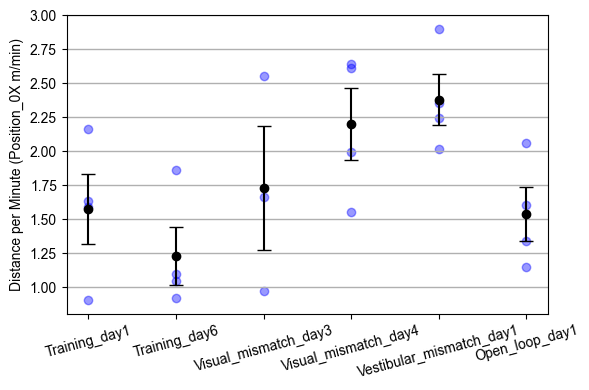

✅ Plot saved as: distance_and_speed_comparison.png


In [2]:
# === Plot ===
plt.rcParams.update({
    'font.size': 10,           # Set global font size
    'font.family': 'sans-serif',  # Font family (e.g., 'serif', 'sans-serif', 'monospace')
    'font.sans-serif': ['Arial'],  # Preferred font
    'axes.titlesize': 10,      # Title font size
    'axes.labelsize': 10,      # Axis label size
    'legend.fontsize': 8,     # Legend text
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

if len(distance_data) == 0:
    print("❌ No valid data to plot.")
else:
    fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharey=False)  # Reduced figure size
    axs = [axs]  # Wrap single Axes object in a list for consistent indexing

    # Plot: Distance per minute
    for i, distances in enumerate(distance_data):
        x = i + 1
        mean = distances.mean()
        sem = distances.std(ddof=1) / np.sqrt(len(distances))
        axs[0].scatter(np.full_like(distances, x), distances, alpha=0.4, color='blue')
        axs[0].errorbar(x, mean, yerr=sem, fmt='o', color='black', capsize=5)

    # axs[0].set_title('Distance per Minute')
    axs[0].set_xticks(range(1, len(labels) + 1))
    axs[0].set_xticklabels(labels, rotation=15)
    axs[0].set_ylabel(f'Distance per Minute ({column_to_analyze} m/min)')
    axs[0].grid(True, axis='y', linewidth=1)  # Thicker grid lines
    plt.tight_layout()
    plt.savefig(output_filename, dpi=300)
    plt.show()
    print(f"✅ Plot saved as: {output_filename}")
